<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-anya-23-ct/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
/content/gdrive/MyDrive/ece5545/a2-anya-23-ct
M	3_training_and_analysis.ipynb
M	5_quantization.ipynb
Already on 'main'
Your branch is behind 'origin/main' by 3 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)
Updating 3d08810..6d34fda
error: Your local changes to the following files would be overwritten by merge:
	3_training_and_analysis.ipynb
	5_quantization.ipynb
Please commit your changes or stash them before you merge.
Aborting
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [5]:
!pip install torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 988.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.0 MB/s eta 0:00:00


### Import code dependencies

In [6]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 6.1 Prepare for Training



In [7]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [8]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt	      '(QAT6bit)quant_0.pt'	  quant_checkpoint_6.pt
 fp32_finetune_checkpoint.pt  '(QAT8bit)quant_0.pt'	  quant_checkpoint_8.pt
'(QAT2bit)quant_0.pt'	       quant_checkpoint_2bit.pt   quant_checkpoint.pt
'(QAT4bit)quant_0.pt'	       quant_checkpoint_2.pt	  tinyconv_float32_init_seed0_90.35%_0.pt


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [9]:
# TODO: Replace me!
# torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.35%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

(TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ),
 TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [69]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from src.size_estimate import count_trainable_parameters
from src.size_estimate import flop
from src.train_val_test_utils import test

def structured_pruning(model, threshold, n=1):
  m = copy.deepcopy(model)
  m.to(device)
  for name, module in m.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      prune.ln_structured(module, name='weight', n=n, amount=threshold, dim=0)
      # prune.remove(module, 'weight')
  return m

In [70]:
thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]

In [71]:
pruned_models = {}

for t in thresholds:
  m = structured_pruning(model_fp32,t,n=1) #L1 structured pruning
  m.to(device)
  pruned_models[t]= m

In [72]:
num_params_pruned_models = {}

for t in thresholds:
  m = pruned_models[t]

  num_conv_params = m.conv.weight.numel() + m.conv.bias.numel()
  num_lin_params = m.fc.weight.numel() + m.fc.bias.numel()
  num_params_pruned_estimated = torch.sum(m.conv.weight == 0) + torch.sum(m.fc.weight == 0)
  num_params_after_pruning = num_conv_params + num_lin_params - num_params_pruned_estimated

  num_params_pruned_models[t] = num_params_after_pruning

print('param counts {}'.format(num_params_pruned_models))

param counts {0.1: tensor(16572, device='cuda:0'), 0.25: tensor(12492, device='cuda:0'), 0.5: tensor(8332, device='cuda:0'), 0.75: tensor(4172, device='cuda:0'), 0.9: tensor(92, device='cuda:0')}


In [73]:
test_acc_pruned_models = {}
for t in thresholds:
  m = pruned_models[t]
  acc = test(test_loader, m, device, epoch=None, loader_type='Test')
  test_acc_pruned_models[t] = acc

print('test accuracies {}'.format(test_acc_pruned_models))

test accuracies {0.1: 81.72514619883042, 0.25: 81.14035087719299, 0.5: 49.3421052631579, 0.75: 41.666666666666664, 0.9: 19.883040935672515}


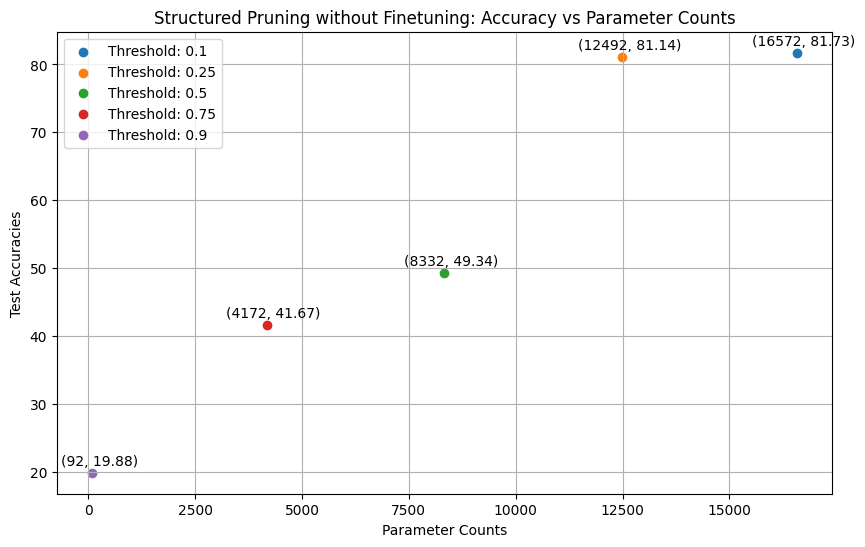

In [187]:
import matplotlib.pyplot as plt

# Example data
param_counts_values = [tensor.cpu() for tensor in num_params_pruned_models.values()]
test_accuracies_values = test_acc_pruned_models.values()
# thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]

# Plot accuracy versus parameter counts
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(zip(param_counts_values, test_accuracies_values)):
    plt.scatter(x, y, label=f'Threshold: {thresholds[i]}')
    plt.annotate(f'({x}, {y:.2f})', (x, y), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('Parameter Counts')
plt.ylabel('Test Accuracies')
plt.title('Structured Pruning without Finetuning: Accuracy vs Parameter Counts')
plt.grid(True)
plt.legend()
plt.show()


In [84]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)

            # Apply pruning masks
            for name, module in model.named_modules():
                if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                    module.weight.data *= module.weight_mask

            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 5
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

#batches: 106 
#epochs: 5 
#total training steps: 530


In [85]:
structured_pruned_models_finetuned = {}

for t in thresholds:
  # Create optimizer
  print('finetuning threshold {}'.format(t))
  m = structured_pruning(model_fp32,t)

  print('m is {}'.format(m))
  optimizer_prune_structured = create_optimizer(model=m, learning_rate=0.0001)
  print(optimizer_prune_structured.state_dict())

  checkpoint_path = os.path.join(TORCH_DIR, "pruned_unstructured_checkpoint_{t}.pt")
  m.to(device)
  run_training(
      model=m, data_loaders=data_loaders,
      n_epoch=5, log_interval=log_interval,
      optimizer=optimizer_prune_structured, scheduler=None,
      resume=False,
      checkpoint_path=checkpoint_path,
      verbose=verbose
  )

  structured_pruned_models_finetuned[t] = m

finetuning threshold 0.1
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

Val Acc Epoch 1 = 89.2%, Train loss = 0.415
Val Acc Epoch 2 = 88.0%, Train loss = 0.397
Val Acc Epoch 3 = 88.22%, Train loss = 0.387
Val Acc Epoch 4 = 89.2%, Train loss = 0.372
Val Acc Epoch 5 = 89.8%, Train loss = 0.369
finetuning threshold 0.25
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.12%, Train loss = 0.53
Val Acc Epoch 2 = 87.02%, Train loss = 0.466
Val Acc Epoch 3 = 86.87%, Train loss = 0.445
Val Acc Epoch 4 = 88.22%, Train loss = 0.426
Val Acc Epoch 5 = 88.6%, Train loss = 0.42
finetuning threshold 0.5
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

Val Acc Epoch 1 = 60.84%, Train loss = 0.984
Val Acc Epoch 2 = 66.02%, Train loss = 0.797
Val Acc Epoch 3 = 68.34%, Train loss = 0.746
Val Acc Epoch 4 = 70.29%, Train loss = 0.721
Val Acc Epoch 5 = 70.59%, Train loss = 0.705
finetuning threshold 0.75
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

Val Acc Epoch 1 = 48.09%, Train loss = 1.191
Val Acc Epoch 2 = 47.94%, Train loss = 1.1
Val Acc Epoch 3 = 48.61%, Train loss = 1.05
Val Acc Epoch 4 = 48.24%, Train loss = 1.022
Val Acc Epoch 5 = 48.24%, Train loss = 1.008
finetuning threshold 0.9
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

Val Acc Epoch 1 = 19.88%, Train loss = 1.421
Val Acc Epoch 2 = 19.88%, Train loss = 1.418
Val Acc Epoch 3 = 19.88%, Train loss = 1.416
Val Acc Epoch 4 = 19.88%, Train loss = 1.413
Val Acc Epoch 5 = 19.88%, Train loss = 1.411


In [86]:
test_acc_structured_pruned_models_finetuned = {}
for t in thresholds:
  print('threshold {}'.format(t))
  m = structured_pruned_models_finetuned[t]
  acc = test(test_loader, m, device, epoch=None, loader_type='Test')
  test_acc_structured_pruned_models_finetuned[t] = acc

print('test accuracies structured finetuned \n {}'.format(test_acc_structured_pruned_models_finetuned))

threshold 0.1
threshold 0.25
threshold 0.5
threshold 0.75
threshold 0.9
test accuracies structured finetuned 
 {0.1: 88.8157894736842, 0.25: 88.37719298245614, 0.5: 70.39473684210526, 0.75: 49.12280701754386, 0.9: 19.883040935672515}


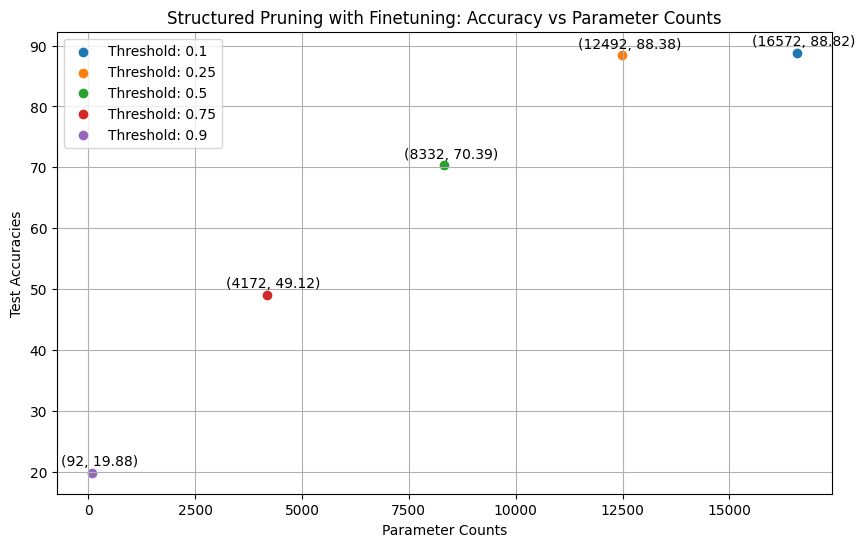

In [94]:
import matplotlib.pyplot as plt

# Example data
param_counts_values = [tensor.cpu() for tensor in num_params_pruned_models.values()]
test_accuracies_values = test_acc_structured_pruned_models_finetuned.values()
# thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]

# Plot accuracy versus parameter counts
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(zip(param_counts_values, test_accuracies_values)):
    plt.scatter(x, y, label=f'Threshold: {thresholds[i]}')
    plt.annotate(f'({x}, {y:.2f})', (x, y), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('Parameter Counts')
plt.ylabel('Test Accuracies')
plt.title('Structured Pruning with Finetuning: Accuracy vs Parameter Counts')
plt.grid(True)
plt.legend()
plt.show()


In [151]:
def check_zeroed_channels(model):
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
      # print('module name {}, type {}'.format(name,module))
      mask = module.weight_mask
      # print('mask shape is {}'.format(mask.shape))
      # print(mask)
      if isinstance(module, nn.Conv2d):
        sum_along_dimensions = torch.sum(mask, dim=(-1,-2))
        # print(sum_along_dimensions.shape)
        # print(sum_along_dimensions)
        num_zero_channels = torch.sum((sum_along_dimensions == 0).int())
        num_nz_channels = 8 - num_zero_channels
        num_fc_feats = num_nz_channels * 500
        # print(f"Module: {name}, Zeroed out channels: {num_zero_channels}")
      # elif isinstance(module,nn.Linear):
        # print('mask is \n {}'.format(mask))
        # num_features_zeroed_out = torch.sum(mask == 0)
        # num_fc_feats = mask.numel() - num_features_zeroed_out
        # print(f"Module: {name}, Zeroed out features: {num_features_zeroed_out}, FC Feats: {num_fc_feats}")
  return num_nz_channels,num_fc_feats

In [152]:
num_nz_ch_per_threshold = {}
num_fc_features_in_per_threshold = {}

for t in thresholds:
  print('threshold {}'.format(t))
  m = pruned_models[t]
  nzc, fc_feat = check_zeroed_channels(m)
  num_nz_ch_per_threshold[t] = nzc.cpu()
  num_fc_features_in_per_threshold[t] = fc_feat.cpu()

print('num_nz_ch_per_threshold is {}'.format(num_nz_ch_per_threshold))
print('num_fc_features_in_per_threshold is {}'.format(num_fc_features_in_per_threshold))

threshold 0.1
threshold 0.25
threshold 0.5
threshold 0.75
threshold 0.9
num_nz_ch_per_threshold is {0.1: tensor(7), 0.25: tensor(6), 0.5: tensor(4), 0.75: tensor(2), 0.9: tensor(1)}
num_fc_features_in_per_threshold is {0.1: tensor(3500), 0.25: tensor(3000), 0.5: tensor(2000), 0.75: tensor(1000), 0.9: tensor(500)}


In [153]:
from src.networks import Reshape,TinyConv

class PrunedTinyConv(TinyConv):
    def __init__(self, model_settings, n_input=1, n_output=4, num_channels=8, fc_feats=16000):
        super(PrunedTinyConv, self).__init__(model_settings, n_input, n_output)
        first_filter_width = 8
        first_filter_height = 10
        first_filter_count = num_channels
        first_conv_stride_x = 2
        first_conv_stride_y = 2
        self.model_settings = model_settings

        input_frequency_size = self.model_settings['fingerprint_width']
        input_time_size = self.model_settings['spectrogram_length']
        W = input_frequency_size
        H = input_time_size
        C = 1

        # Reshape layer
        self.conv_reshape = Reshape([-1, C, H, W])

        # Conv2d layer
        self.conv = nn.Conv2d(in_channels=n_input,
                              out_channels=first_filter_count,
                              kernel_size=
                              (first_filter_height, first_filter_width),
                              stride=(first_conv_stride_y, first_conv_stride_x),
                              padding=(5, 3))

        # Relu layer
        self.relu = nn.ReLU()

        # Dropout layer
        self.dropout = nn.Dropout()

        # Reshape layer
        fc_in_features = fc_feats
        self.fc_reshape = Reshape([-1, fc_in_features])

        # Fully Connected layer
        self.fc = nn.Linear(in_features=fc_in_features, out_features=n_output)

        # Softmax
        self.softmax = torch.nn.Softmax(dim=1)

In [165]:
from src.size_estimate import flop
flops_per_threshold_struct_pruned = {}

for t in thresholds:
  nc = num_nz_ch_per_threshold[t]
  num_fc_feats = num_fc_features_in_per_threshold[t]
  m_count_flops = PrunedTinyConv(model_settings=audio_processor.model_settings,n_input=1, n_output=audio_processor.num_labels, num_channels=nc, fc_feats=num_fc_feats)
  if torch.cuda.is_available():
    m_count_flops.cuda()
  flop_by_layers = flop(
      model=m_count_flops,
      input_shape=(
          1,
          m_count_flops.model_settings['fingerprint_width'],
          m_count_flops.model_settings['spectrogram_length']
      ),
      device=device)
  total_param_flops = sum([sum(val.values()) for val in flop_by_layers.values()])
  flops_per_threshold_struct_pruned[t] = total_param_flops / 1000

print('flops_per_threshold_struct_pruned is {}'.format(flops_per_threshold_struct_pruned))

flops_per_threshold_struct_pruned is {0.1: 591.504, 0.25: 507.004, 0.5: 338.004, 0.75: 169.004, 0.9: 84.504}


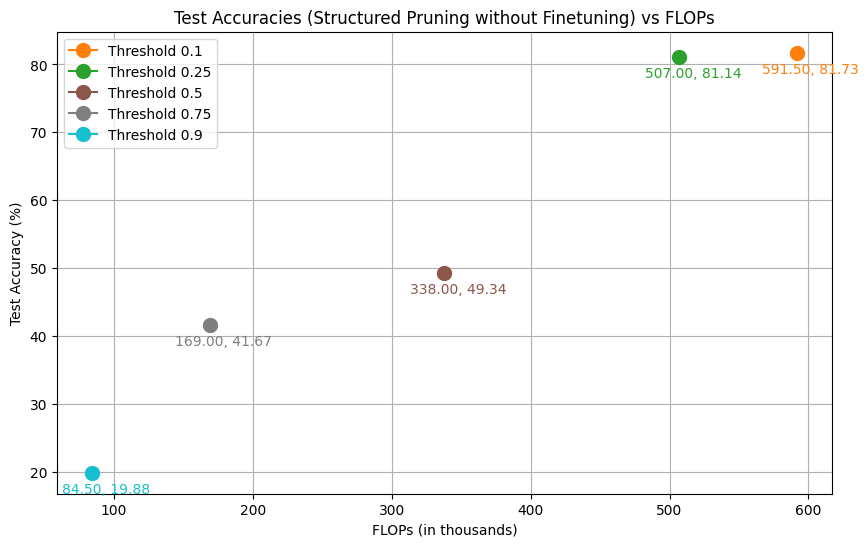

In [186]:
import matplotlib.pyplot as plt

accuracies = list(test_acc_pruned_models.values())
flops = list(flops_per_threshold_struct_pruned.values())

# Plot
plt.figure(figsize=(10, 6))

# Annotate thresholds with legend
for threshold, flops_val, acc_val in zip(thresholds, flops, accuracies):
    plt.plot(flops_val, acc_val, marker='o', markersize=10, label=f'Threshold {threshold}', color=f'C{int(threshold*10)}')
    plt.annotate(f'{flops_val:.2f}, {acc_val:.2f}', (flops_val, acc_val), textcoords="offset points", xytext=(10,-15), ha='center', color=f'C{int(threshold*10)}')

plt.xlabel('FLOPs (in thousands)')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracies (Structured Pruning without Finetuning) vs FLOPs')
plt.legend()
plt.grid(True)
plt.show()


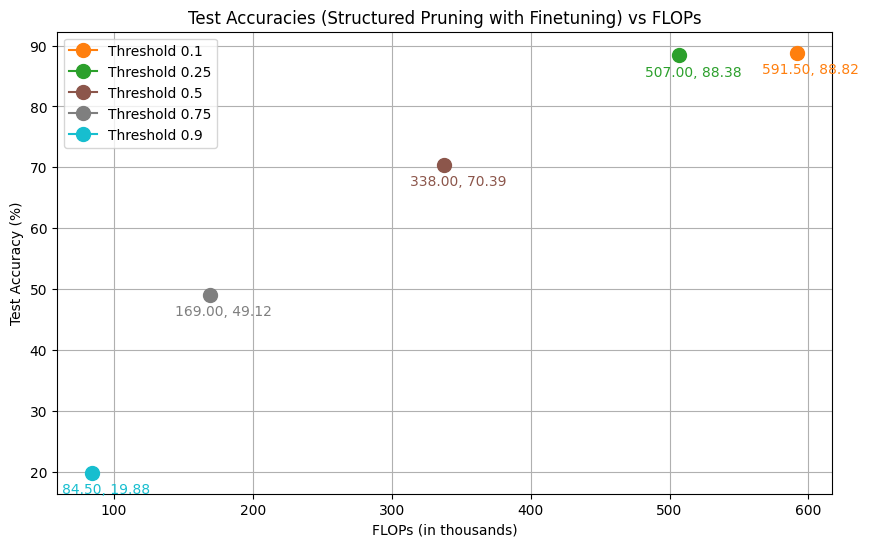

In [185]:
import matplotlib.pyplot as plt

accuracies = list(test_acc_structured_pruned_models_finetuned.values())
flops = list(flops_per_threshold_struct_pruned.values())

# Plot
plt.figure(figsize=(10, 6))

# Annotate thresholds with legend
for threshold, flops_val, acc_val in zip(thresholds, flops, accuracies):
    plt.plot(flops_val, acc_val, marker='o', markersize=10, label=f'Threshold {threshold}', color=f'C{int(threshold*10)}')
    plt.annotate(f'{flops_val:.2f}, {acc_val:.2f}', (flops_val, acc_val), textcoords="offset points", xytext=(10,-15), ha='center', color=f'C{int(threshold*10)}')

plt.xlabel('FLOPs (in thousands)')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracies (Structured Pruning with Finetuning) vs FLOPs')
plt.legend()
plt.grid(True)
plt.show()

In [176]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.rand([1,1960]).cpu()

for t in thresholds:
  print('threshold is {}'.format(t))
  nc = num_nz_ch_per_threshold[t]
  num_fc_feats = num_fc_features_in_per_threshold[t]
  m_count_flops = PrunedTinyConv(model_settings=audio_processor.model_settings,n_input=1, n_output=audio_processor.num_labels, num_channels=nc, fc_feats=num_fc_feats)
  m.to('cpu')
  # if torch.cuda.is_available():
  #   m_count_flops.cuda()
  #   inputs = inputs.cuda()

  with profile(activities=[ProfilerActivity.CPU], record_shapes=True, with_flops=True, with_stack=True) as prof:
      with record_function("model_inference"):
          m_count_flops(inputs)
  print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

threshold is 0.1
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  Total KFLOPs  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
              model_inference         0.46%     730.000us       100.00%     159.192ms     159.192ms             1            --  
                 aten::conv2d         0.01%      15.000us        90.78%     144.511ms     144.511ms             1       560.000  
            aten::convolution         0.03%      52.000us        90.77%     144.496ms     144.496ms             1            --  
           aten::_convolution         0.02%      33.000us        90.74%     144.444ms     144.444ms             1            --  
     aten::mkldnn_convolution        90.69%     144.370ms        90.71%  

In [177]:
cpu_time_per_threshold_struct_pruned = {}
cpu_time_per_threshold_struct_pruned[0.1] = 159.192
cpu_time_per_threshold_struct_pruned[0.25] = 1.070
cpu_time_per_threshold_struct_pruned[0.5] = 1.013
cpu_time_per_threshold_struct_pruned[0.75] = 0.964
cpu_time_per_threshold_struct_pruned[0.9] = 8.478

print('cpu_time_per_threshold_struct_pruned is {}'.format(cpu_time_per_threshold_struct_pruned))

cpu_time_per_threshold_struct_pruned is {0.1: 159.192, 0.25: 1.07, 0.5: 1.013, 0.75: 0.964, 0.9: 8.478}


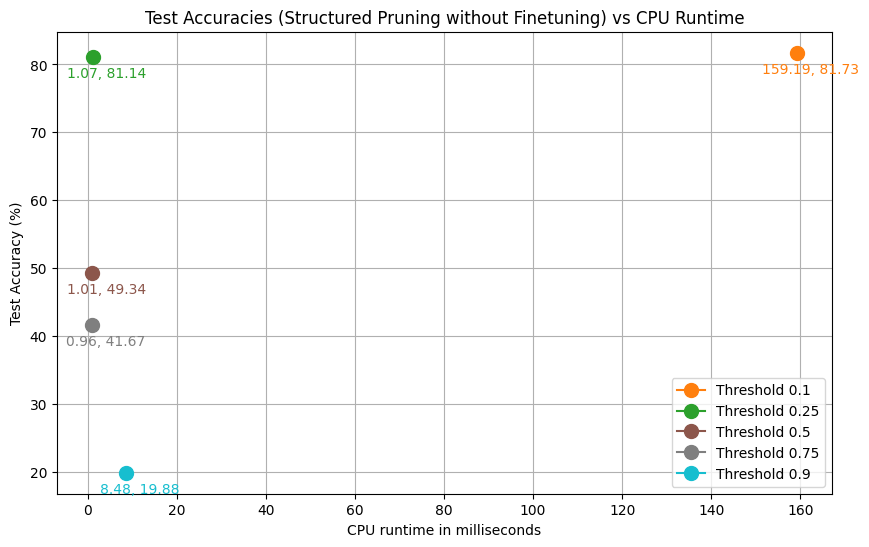

In [184]:
import matplotlib.pyplot as plt

accuracies = list(test_acc_pruned_models.values())
flops = list(cpu_time_per_threshold_struct_pruned.values())

# Plot
plt.figure(figsize=(10, 6))

# Annotate thresholds with legend
for threshold, flops_val, acc_val in zip(thresholds, flops, accuracies):
    plt.plot(flops_val, acc_val, marker='o', markersize=10, label=f'Threshold {threshold}', color=f'C{int(threshold*10)}')
    plt.annotate(f'{flops_val:.2f}, {acc_val:.2f}', (flops_val, acc_val), textcoords="offset points", xytext=(10,-15), ha='center', color=f'C{int(threshold*10)}')

plt.xlabel('CPU runtime in milliseconds')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracies (Structured Pruning without Finetuning) vs CPU Runtime')
plt.legend()
plt.grid(True)
plt.show()

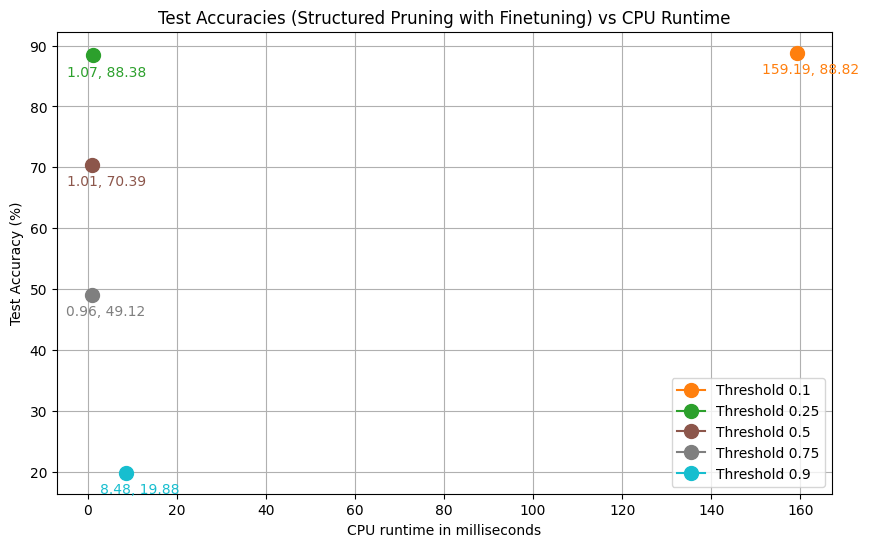

In [183]:
import matplotlib.pyplot as plt

accuracies = list(test_acc_structured_pruned_models_finetuned.values())
flops = list(cpu_time_per_threshold_struct_pruned.values())

# Plot
plt.figure(figsize=(10, 6))

# Annotate thresholds with legend
for threshold, flops_val, acc_val in zip(thresholds, flops, accuracies):
    plt.plot(flops_val, acc_val, marker='o', markersize=10, label=f'Threshold {threshold}', color=f'C{int(threshold*10)}')
    plt.annotate(f'{flops_val:.2f}, {acc_val:.2f}', (flops_val, acc_val), textcoords="offset points", xytext=(10,-15), ha='center', color=f'C{int(threshold*10)}')

plt.xlabel('CPU runtime in milliseconds')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracies (Structured Pruning with Finetuning) vs CPU Runtime')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# convvert models to TFLite

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [24]:
import copy
import torch.nn as nn
import torch.nn.utils.prune as prune

In [60]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            print('epoch {}'.format(epoch))
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)

            # Apply pruning masks
            for name, module in model.named_modules():
                if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                    module.weight.data *= module.weight_mask

            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 5
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

#batches: 106 
#epochs: 5 
#total training steps: 530


In [49]:
def unstructured_pruning(model, threshold):
    model_copy = copy.deepcopy(model)
    for modname, module in model_copy.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, 'weight', threshold)

    # Freeze pruned weights
    for name, param in model_copy.named_parameters():
        if 'weight' in name and hasattr(param, 'orig'):
            param.requires_grad = False

    # optimizer_prune_unstructured = create_optimizer(model=model_copy, learning_rate=0.0001)
    # print(optimizer_prune_unstructured.state_dict())

    # print('fine tuning now \n')

    # non_finetuned_model = copy.deepcopy(model_copy)

    # checkpoint_path = os.path.join(TORCH_DIR, "pruned_unstructured_checkpoint_{t}.pt")
    # model_copy.to(device)

    # run_training(
    #     model=model_copy, data_loaders=data_loaders,
    #     n_epoch=5, log_interval=log_interval,
    #     optimizer=optimizer_prune_unstructured, scheduler=None,
    #     resume=False,
    #     checkpoint_path=checkpoint_path,
    #     verbose=verbose
    # )

    # return non_finetuned_model, model_copy

    return model_copy

In [50]:
unstructured_pruned_models = {}

for t in thresholds:
  m = unstructured_pruning(model_fp32,t)
  m.to(device)
  unstructured_pruned_models[t] = m
  # m_pruned_unstr, m_pruned_unstr_finetuned = unstructured_pruning(model_fp32,t) #L1 structured pruning
  # m_pruned_unstr.to(device)
  # m_pruned_unstr_finetuned.to(device)
  # unstructured_pruned_models[t]= m_pruned_unstr
  # unstructured_pruned_models_finetuned[t] = m_pruned_unstr_finetuned

In [51]:
num_params_unstructured_pruned_models = {}

for t in thresholds:
  m = unstructured_pruned_models[t]

  num_conv_params = m.conv.weight.numel() + m.conv.bias.numel()
  num_lin_params = m.fc.weight.numel() + m.fc.bias.numel()
  num_params_pruned_estimated = torch.sum(m.conv.weight == 0) + torch.sum(m.fc.weight == 0)
  num_params_after_pruning = num_conv_params + num_lin_params - num_params_pruned_estimated

  num_params_unstructured_pruned_models[t] = num_params_after_pruning

print('param counts {}'.format(num_params_unstructured_pruned_models))

param counts {0.1: tensor(14988), 0.25: tensor(12492), 0.5: tensor(8332), 0.75: tensor(4172), 0.9: tensor(1676)}


In [52]:
test_acc_unstructured_pruned_models = {}
for t in thresholds:
  print('threshold {}'.format(t))
  m = unstructured_pruned_models[t]
  acc = test(test_loader, m, device, epoch=None, loader_type='Test')
  test_acc_unstructured_pruned_models[t] = acc

print('test accuracies {}'.format(test_acc_unstructured_pruned_models))

threshold 0.1
threshold 0.25
threshold 0.5
threshold 0.75
threshold 0.9
test accuracies {0.1: 90.49707602339181, 0.25: 90.42397660818713, 0.5: 73.75730994152046, 0.75: 34.50292397660819, 0.9: 25.219298245614034}


In [62]:
unstructured_pruned_models_finetuned = {}

for t in thresholds:
  # Create optimizer
  print('finetuning threshold {}'.format(t))
  m = unstructured_pruning(model_fp32,t)

  print('m is {}'.format(m))
  optimizer_prune_unstructured = create_optimizer(model=m, learning_rate=0.0001)
  print(optimizer_prune_unstructured.state_dict())

  checkpoint_path = os.path.join(TORCH_DIR, "pruned_unstructured_checkpoint_{t}.pt")
  m.to(device)
  run_training(
      model=m, data_loaders=data_loaders,
      n_epoch=5, log_interval=log_interval,
      optimizer=optimizer_prune_unstructured, scheduler=None,
      resume=False,
      checkpoint_path=checkpoint_path,
      verbose=verbose
  )

  unstructured_pruned_models_finetuned[t] = m

finetuning threshold 0.1
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1
Val Acc Epoch 1 = 91.37%, Train loss = 0.322
epoch 2
Val Acc Epoch 2 = 91.07%, Train loss = 0.299
epoch 3
Val Acc Epoch 3 = 91.45%, Train loss = 0.31
epoch 4
Val Acc Epoch 4 = 90.62%, Train loss = 0.31
epoch 5
Val Acc Epoch 5 = 91.97%, Train loss = 0.312
finetuning threshold 0.25
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1
Val Acc Epoch 1 = 91.07%, Train loss = 0.318
epoch 2
Val Acc Epoch 2 = 91.07%, Train loss = 0.302
epoch 3
Val Acc Epoch 3 = 91.45%, Train loss = 0.307
epoch 4
Val Acc Epoch 4 = 91.15%, Train loss = 0.309
epoch 5
Val Acc Epoch 5 = 91.37%, Train loss = 0.305
finetuning threshold 0.5
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1
Val Acc Epoch 1 = 89.65%, Train loss = 0.591
epoch 2
Val Acc Epoch 2 = 90.17%, Train loss = 0.348
epoch 3
Val Acc Epoch 3 = 89.8%, Train loss = 0.331
epoch 4
Val Acc Epoch 4 = 90.4%, Train loss = 0.334
epoch 5
Val Acc Epoch 5 = 90.4%, Train loss = 0.33
finetuning threshold 0.75
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1
Val Acc Epoch 1 = 60.99%, Train loss = 3.051
epoch 2
Val Acc Epoch 2 = 67.74%, Train loss = 1.575
epoch 3
Val Acc Epoch 3 = 70.37%, Train loss = 1.181
epoch 4
Val Acc Epoch 4 = 75.17%, Train loss = 0.997
epoch 5
Val Acc Epoch 5 = 77.27%, Train loss = 0.853
finetuning threshold 0.9
m is TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
{'state': {}, 'param_groups': [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1
Val Acc Epoch 1 = 25.96%, Train loss = 4.073
epoch 2
Val Acc Epoch 2 = 31.28%, Train loss = 2.745
epoch 3
Val Acc Epoch 3 = 39.91%, Train loss = 2.022
epoch 4
Val Acc Epoch 4 = 48.61%, Train loss = 1.604
epoch 5
Val Acc Epoch 5 = 51.24%, Train loss = 1.403


In [63]:
test_acc_unstructured_pruned_models_finetuned = {}
for t in thresholds:
  print('threshold {}'.format(t))
  m = unstructured_pruned_models_finetuned[t]
  acc = test(test_loader, m, device, epoch=None, loader_type='Test')
  test_acc_unstructured_pruned_models_finetuned[t] = acc

print('test accuracies unstructured finetuned \n {}'.format(test_acc_unstructured_pruned_models_finetuned))

threshold 0.1
threshold 0.25
threshold 0.5
threshold 0.75
threshold 0.9
test accuracies unstructured finetuned 
 {0.1: 90.27777777777777, 0.25: 91.81286549707602, 0.5: 90.27777777777777, 0.75: 78.58187134502924, 0.9: 52.77777777777778}


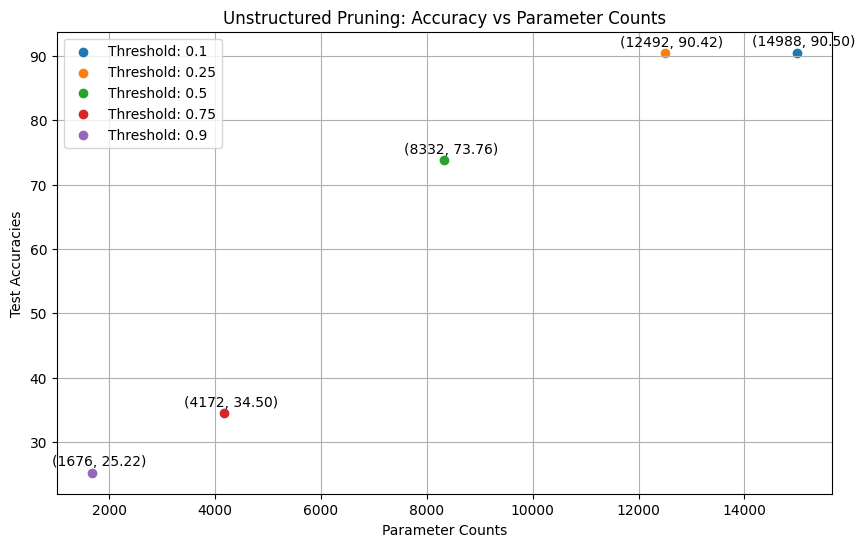

In [82]:
import matplotlib.pyplot as plt

# Example data
param_counts_values = num_params_unstructured_pruned_models.values()
test_accuracies_values = test_acc_unstructured_pruned_models.values()
# test_accuracies_values_fine = test_acc_unstructured_pruned_models_finetuned

# Plot accuracy versus parameter counts
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(zip(param_counts_values, test_accuracies_values)):
    plt.scatter(x, y, label=f'Threshold: {thresholds[i]}')
    plt.annotate(f'({x}, {y:.2f})', (x, y), textcoords="offset points", xytext=(5,5), ha='center')
plt.xlabel('Parameter Counts')
plt.ylabel('Test Accuracies')
plt.title('Unstructured Pruning: Accuracy vs Parameter Counts')
plt.grid(True)
plt.legend()
plt.show()


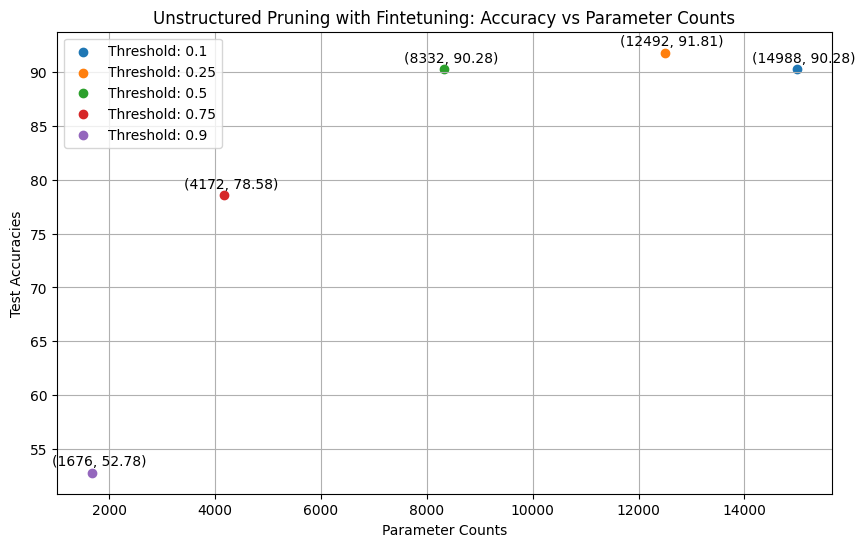

In [83]:
import matplotlib.pyplot as plt

# Example data
param_counts_values = num_params_unstructured_pruned_models.values()
test_accuracies_values_fine = test_acc_unstructured_pruned_models_finetuned.values()

# Plot accuracy versus parameter counts
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(zip(param_counts_values, test_accuracies_values_fine)):
    plt.scatter(x, y, label=f'Threshold: {thresholds[i]}')
    plt.annotate(f'({x}, {y:.2f})', (x, y), textcoords="offset points", xytext=(5,5), ha='center')
plt.xlabel('Parameter Counts')
plt.ylabel('Test Accuracies')
plt.title('Unstructured Pruning with Fintetuning: Accuracy vs Parameter Counts')
plt.grid(True)
plt.legend()
plt.show()
